In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


mp.verbosity(0)


1

In [2]:
a = 0.775
r,h,wl, = 0.315*a,0.3,1.55
x_num,y_num = 20,6
wg_wight = y_num*np.sqrt(3)*a*2
block_x,block_y=0,0
Block_x,Block_y=x_num*a,wg_wight
x_length = 3 
y_length = np.sqrt(3)*a
block_x1= -x_num*0.5*a-x_length*0.5
block_x2= -block_x1
aa=4
resolution = 10  # pixels/um



dpml = 1.0
pml_layers = [mp.PML(dpml)]

sx = Block_x + 2 * x_length + 2*aa + 2*dpml  # size of cell in X direction
sy = Block_y + 2*dpml  # size of cell in Y direction
cell = mp.Vector3(sx, sy, 0)

nfreq = 100  # number of frequencies at which to compute flux
fcen = 0.15  # pulse center frequency
df = 0.1  # pulse width (in frequency)

source_center=mp.Vector3(-sx/2+2, 0, 0)
refl_monitor=mp.Vector3(-sx/2+dpml+2,0,0)
trans_monitor=mp.Vector3(sx/2-dpml-1,0,0)


def lno(a):
    b = 1+2.6734*a**2/(a**2-0.01764)+1.2290*a**2/(a**2-0.0591)+12.614*a**2/(a**2-474.60)
    return b
def lne(a):
    b = 1+2.9804*a**2/(a**2-0.02047)+0.5981*a**2/(a**2-0.0666)+8.9543*a**2/(a**2-416.08)
    return b


def add_cylinder(local):
    a = mp.Cylinder(radius=r,height=h,center=local,material=mp.air)
    return a


LN = mp.Medium(epsilon_diag=(lno(wl),lne(wl),lno(wl)))




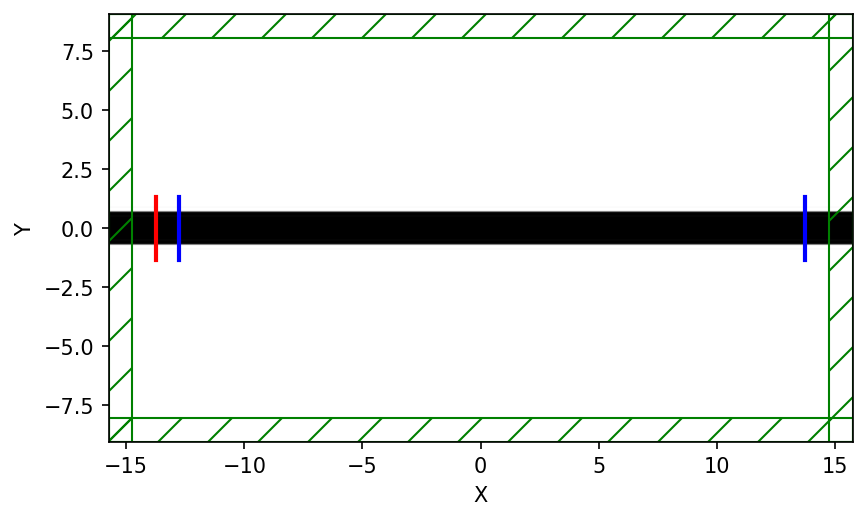

In [3]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, y_length, mp.inf),
        center=mp.Vector3(0, 0, 0),
        material=LN,
    )
]

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=source_center,
        size=mp.Vector3(0, 2*y_length, 0),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)


refl_fr = mp.FluxRegion(
    center=refl_monitor, size=mp.Vector3(0, 2 * y_length, 0)
)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=trans_monitor, size=mp.Vector3(0, 2*y_length, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

In [4]:
#pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, trans_monitor, 1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

In [5]:
# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

<Axes: xlabel='X', ylabel='Y'>

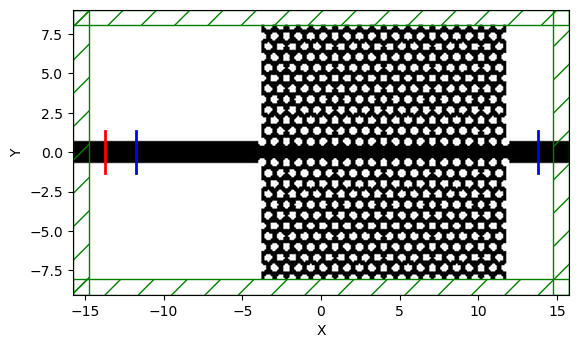

In [6]:
sim.reset_meep()


#############################################



geometry = [mp.Block(size=mp.Vector3(mp.inf,y_length, mp.inf),
                       center=mp.Vector3(block_x1,0),material=LN),]

geometry += [mp.Block(size=mp.Vector3(Block_x,Block_y, mp.inf),
                     center=mp.Vector3(block_x+aa,block_y),material=LN)]
# geometry += [mp.Block(size=mp.Vector3(x_length,y_length,z_length),
#                       center=mp.Vector3(block_x1,0,0),material=LN),
#              mp.Block(size=mp.Vector3(x_length,y_length,z_length),
#                       center=mp.Vector3(block_x2,0,0),material=LN)]
for i in np.linspace(-x_num*0.5*a,x_num*0.5*a,x_num+1):
    for j in np.linspace(-y_num*np.sqrt(3)*a,y_num*np.sqrt(3)*a,2*y_num+1):
        if j != 0:
            geometry += [add_cylinder(mp.Vector3(i+0.5*a+aa,j)),
                         add_cylinder(mp.Vector3(i+aa,j+np.sqrt(3)*0.5*a))]
        else:
            geometry += [add_cylinder(mp.Vector3(i+aa,np.sqrt(3)*0.5*a))]


sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=source_center,
        size=mp.Vector3(0, 2*y_length, 0),
    )
]

########################################################

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

refl_fr = mp.FluxRegion(
    center=mp.Vector3(-sx/2+4, 0, 0), size=mp.Vector3(0, 2 * y_length, 0)
)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=mp.Vector3(sx/2-2, 0, 0), size=mp.Vector3(0, 2*y_length, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

sim.plot2D()


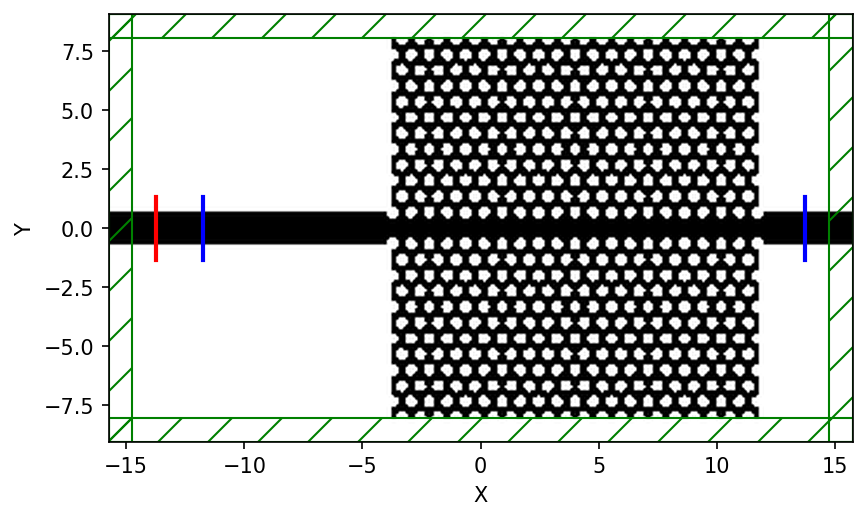

In [7]:
# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

#pt = mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, trans_monitor, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

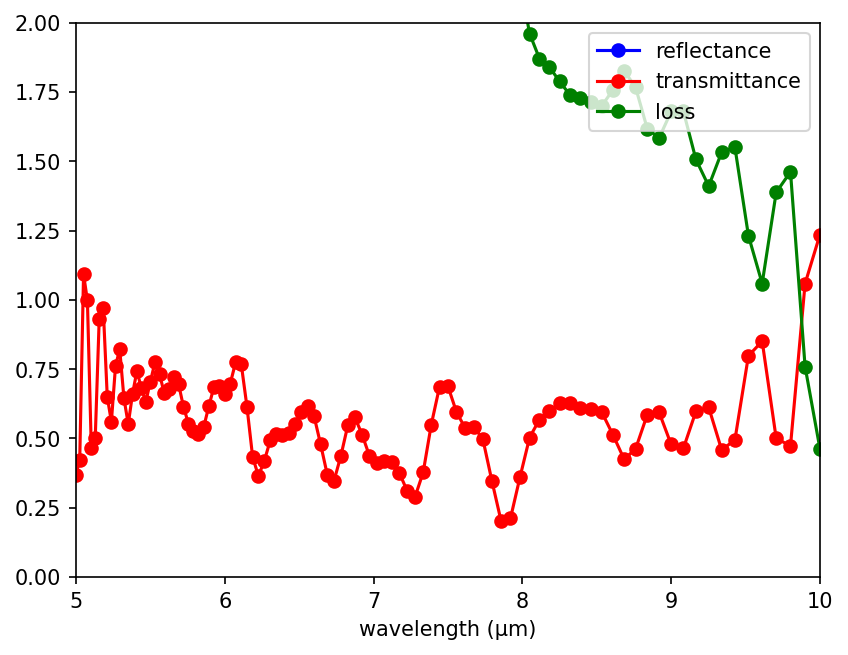

In [10]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

plt.figure(dpi=150)
plt.plot(wl, Rs, "bo-", label="reflectance")
plt.plot(wl, Ts, "ro-", label="transmittance")
plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
#plt.axis([5.0, 10.0, 0, 1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
sim.plot2D()